# Extracting sentiment from Movie Review Text

The dataset can be downloaded here: <a href = https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz>https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz</a> 

This dataset is a collection of movie reviews from IMDb. The reviews are all highly positive or negative, and no more than 30 reviews from the same movie are in the dataset. I'm going to try to analyze the text using bag of words and tfidf then using basic SVM. Then, I will try some ensemble models such as random forest, gradient boosting, and stacking with pipelines to improve the models. <span style='color:red'>Finish Later With final Results</span>

## The Data

Here I am defining a method to convert the giant folder archive into a large dataframe that I can work with easier. I also pickle the dataframe for fast retrieval later.

In [8]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

In [9]:
def read_dataset(firstTime = False):
    if not firstTime:
        return pickle.load(open('data/IMDb.pkl', 'rb'))
    
    headers = ["id", "rating", "text", "sentiment"]
    data = []
    for file in os.listdir("aclImdb/train/pos"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/train/pos/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 1])
    
    for file in os.listdir("aclImdb/train/neg"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/train/neg/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 0])
        
    for file in os.listdir("aclImdb/test/pos"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/test/pos/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 1])
    
    for file in os.listdir("aclImdb/test/neg"):
        id, rating = file.split("_")
        rating, _ = rating.split(".")
        text = open("aclImdb/test/neg/" + file).read()
        id = int(id)
        rating = int(rating)
        data.append([id, rating, text, 0])
    
    df = pd.DataFrame(data, columns=headers)
    pickle.dump(df, open('data/IMDb.pkl', 'wb'))
    return df

In [10]:
data = read_dataset()

Here's the structure of the archive, as described by the authors:

```bash
aclImdb
├──test
│   ├──pos
│   └──neg
├──train
│   ├──pos
│   ├──neg
│   └──unsup

```

A 50-50 test-train split has already been made, but I want an 80-20 split so I'm going to combine both folders. The "pos" and "neg" folders inside the test and train contain pre-classified reviews, which is what I use to assign column values in the read_dataset method above. The file names contain additional info about the actual rating and the ID of the review.

The features in the dataset are:
  - text
  - sentiment: whether the review was positive (1) or negative (0)
  - rating: the rating of the review (1-10)
  - id: the ID of the review

In [11]:
data.isna().sum()

id           0
rating       0
text         0
sentiment    0
dtype: int64

Looks like there's no missing data or anything. I'll check the distribution of the sentiment column to see if there's any imbalance.

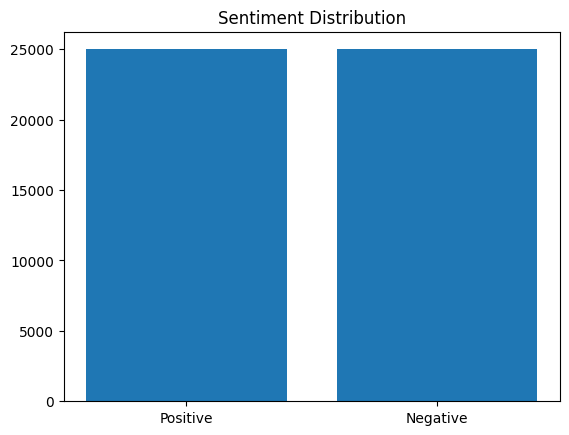

Positive percentage: 0.5


In [12]:
pos = data[data['sentiment'] == 1]
neg = data[data['sentiment'] == 0]

plt.title("Sentiment Distribution")
plt.bar(['Positive', 'Negative'], [pos.shape[0], neg.shape[0]])
plt.show()

print(f"Positive percentage: {data.sentiment.mean()}")

The dataset is perfectly balanced, which is great. There's no real preprocessing to do here because of how clean the dataset is already.

## Feature Extraction

I'll start with CountVectorizer to do bag of words encoding on the review texts, and then see how it performs with a subset of the data using KNN.

In [13]:
reduced_data = data[::25]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(reduced_data['text'], reduced_data['sentiment'], test_size=0.2, random_state=102)

vectorizer = CountVectorizer()
vectorizer.fit(reduced_data['text'])
X_train = vectorizer.transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

In [14]:
bowmodel = KNeighborsClassifier()
bowmodel.fit(X_train, y_train)

cvscore = cross_val_score(bowmodel, X_train, y_train, cv=5)
print(f"Accuracy: {np.mean(cvscore)} ± {np.stdev(cvscore)}")

array([0.603125, 0.546875, 0.56875 , 0.603125, 0.621875])